# ECE/CS 434 | MP3: IMU PDR
<br />
<nav>
    <span class="alert alert-block alert-warning">Due at 11:59PM March 6th 2023 on Gradescope</span> |
    <a href="https://courses.grainger.illinois.edu/cs434/sp2024/">Course Website</a> | 
</nav><br> 

**Name:** Kyle Chung<br>
**NetID:** kbchung2

<hr />  

## Objective
In this MP, you will:
- Implement a step estimation algorithm using accelerometer data.
- Apply signal processing and linear algebra functions such as low/high pass filtering, peak detection, fft, etc. to the step estimation algorithm. 
- Track phone orientation through a sequence of gyroscope data by performing integration.
- Implement simple PDR algorithm: find the final position of the user using steps, orientations and initial position

---
## Problem Overview
In pedestrian dead-reckoning applications, two pieces of information need to be tracked: how far a user walked, and the direction of the walk. In the first part of this MP, you will derive the final orientation using a sequence of gyroscope data. In the second part, you will write a step estimation algorithm using accelerometer data as input and use it to calculate the final position of the user. 

---
## Imports & Setup

### Installing requirements correctly

First. we will make sure that the correct versions of required modules are installed. This ensures that your local Python environment is consistent with the one running on the Gradescope autograder. Just convert the following cell to code and run:

<div class="alert alert-block alert-info"><b>Note:</b> It's preferred that your local environment matches the autograder to prevent possible inconsistencies. However, if you're running into annoying Python version issues but haven't had any issues getting consistent results on the autograder, there is no need to stress over it. Just skip for now and come back when you do encounter inconsistencies:) Ditto below.
</div>

### Your imports
Write your import statements below. If Gradescope reports an error and you believe it is due to an unsupported import, check with the TA to see if it could be added.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from pathlib import Path
import math

# This function is used to format test results. You don't need to touch it.
def display_table(data):
    from IPython.display import HTML, display

    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>{}</h4><td>".format(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

### Sanity-check

Running the following code block verifies that the correct module versions are indeed being used. 

Try restarting the Python kernel (or Jupyter) if there is a mismatch even after intalling the correct version. This might happen because Python's `import` statement does not reload already-loaded modules even if they are updated.

In [2]:
if __name__ == '__main__':
    from IPython.display import display, HTML

    def printc(text, color):
        display(HTML("<text style='color:{};weight:700;'>{}</text>".format(color, text)))

    _requirements = [r.split("==") for r in open(
        "requirements.txt", "r").read().strip().split("\n")]

    import sys
    for (module, expected_version) in _requirements:
        try:
            if sys.modules[module].__version__ != expected_version:
                printc("[✕] {} version should to be {}, but {} is installed.".format(
                    module, expected_version, sys.modules[module].__version__), "#f44336")
            else:
                printc("[✓] {} version {} is correct.".format(
                    module, expected_version), "#4caf50")
        except:
            printc("[–] {} is not imported, skipping version check.".format(
                module), "#03a9f4")

---
## Part 1. 3D Orientation Tracking

Assume that phone is static and phone's local coordinate frame and global/world coordinate frame are aligned at the initial moment. Perform gyro integration for each timestamp onward to calculate the phone's orientation. We will provide you with a trace of gyroscope data in CSV format. There are three columns in the file, representing the gyroscope readings in three **local** axes (unit: $rad / s$). The gyroscope is sampled at 100Hz. Your task is to track the phone’s 3D orientation and **output the end direction in which the phone’s local X axis is pointing at in the global frame**.

One way of solving this problem can be:
<ol type="A">
    <li> Assume the gyroscope’s sample interval is $\Delta t$. </li>
    <li> Get the phone's instant rotation axis and rotation angle in the local frame $(\vec{l}, \Delta \theta)$ for each time stamp $t_{i},$ where $\vec{l}=\left(\omega_{x}, \omega_{v}, \omega_{z}\right)$ and $\Delta \theta=\sqrt{\left(\omega_{x}^{2}+\omega_{v}^{2}+\omega_{z}^{2}\right)} \cdot \Delta t$ </li>
    <li> Project the instant rotation axis $\vec{l}$ into the global frame using the phone's $3 \mathrm{D}$ orientation matrix $R_{i}$ at time $t_{i}$. </li>
    <li> Convert the instant rotation axis and angle in global frame into the form of rotation matrix $\Delta R_{i}$. </li>
    <li> Find the total 3D rotation matrix for time $t_{i+1}: R_{i+1}=\Delta R_{i} \cdot R_{i}$ </li>
</ol>

--- 
**Implement the above algorithm in `track_orientation(gyro_file)` below.** 

Do <b>NOT</b> change the function signature. You are, however, free to define and use helper functions.

In [17]:
# This function takes 1 argument:
#     - gyro_file (string) - name of file containing a sequence of gyroscope data
# It returns an array representing the final global direction
# in which the phone's local X axis is pointing.
def track_orientation(gyro_file):
    # Your implementation starts here:
    gyro_data = np.array(pd.read_csv(gyro_file,header= None)) # Get data using csv file
    sample_interval = 0.01 # sampling rate is 100 Hz, thus 1/100 = 0.01 seconds
    
    
    ## Get rotation axis and rotation angle. Intermediate step. Rotation axis = (w1, w2, w3). delta Rotation angle = norm_2(rotation_axis) * deltat
    rot_axis = np.zeros( (len(gyro_data), 3) ) # rotation axis
    rot_angle = np.zeros(len(gyro_data)) # rotation angle (Note, this is the CUMULATIVE rotation angle)
    cum_rot_angle = 0
    for gyro_time, gyro_datapoint in enumerate(gyro_data): # loop through data points.
        rot_axis[gyro_time] = gyro_datapoint # get 3 datapoints of gyro_data (w1,w2,w3)
        cum_rot_angle += np.linalg.norm(gyro_datapoint) * sample_interval # get delta rotation angle (norm_2 (rotation_axis) * sample_interval)
        rot_angle[gyro_time]=cum_rot_angle  # Get rotation angle 
    print(rot_axis)
    print(rot_angle)
    # projectMatX = np.array([[1,0,0],
    #                             [0,np.cos(rot_angle[0]), -np.sin(rot_angle[0])],
    #                             [0, np.sin(rot_angle[0]), np.cos(rot_angle[0])]]) # initialize 3d orientation matrix FOR THE X-AXIS
    # rot_x, rot_y, rot_z = rot_axis[0]
    # crossPmat = np.array([    [0,-rot_z,rot_y],
    #                           [rot_z, 0, -rot_x],
    #                           [-rot_y,rot_x  ,0]  ]) # Form the original cross product matrix
    # global_rot_mat = np.cos(rot_angle[0]) * np.eye(3)  + np.sin(rot_angle[0]) * crossPmat + (1 - np.cos(rot_angle[0]) ) * np.outer(rot_axis[0],rot_axis[0]) # Convert rotation axis and angle in global frame at time ti into deltaR
    global_rot_mat = np.eye(3) # initialize global rotation matrix
    global_rot_angle = 0
    for i,l in enumerate(rot_axis):
       
        global_rot_axis = global_rot_mat @ (l * sample_interval) # transform rotation axis from local to global
        global_rot_angle = np.linalg.norm(global_rot_axis)
        global_rot_axis /= global_rot_angle
        g_rot_x, g_rot_y, g_rot_z = global_rot_axis
        crossPmat2 = np.array([[0, -g_rot_z, g_rot_y],
                               [g_rot_z, 0, -g_rot_x],
                               [-g_rot_y, g_rot_x,0]])
        deltaR = np.cos(global_rot_angle) * np.eye(3)  + np.sin(global_rot_angle) * crossPmat2 + (1 - np.cos(global_rot_angle) ) * np.outer(l,l) # Convert rotation axis and angle in global frame at time ti into deltaR
        # print("deltaR: ", deltaR)
        global_rot_mat =   deltaR @ global_rot_mat # update global rotation matrix at time ti
    # print(gyro_data)
    # return [0.0, 0.0, 1.0]
    # final_orientation = rot_axis[0]
    # for l in rot_axis:
    #     final_orientation = global_rot_mat @ l
    print (global_rot_mat)
    final_orientation = global_rot_mat @ np.array([1,0,0])
    return (1/  np.linalg.norm(final_orientation)) * final_orientation
track_orientation("orient_data/gyro.csv")

[[ 8.490000e-04  1.839149e-03 -2.470000e-04]
 [-2.347132e-03 -1.356363e-03 -2.377717e-03]
 [ 8.490000e-04  7.740000e-04 -2.470000e-04]
 ...
 [-1.300000e-04  7.710000e-05 -2.251548e-03]
 [-1.300000e-04  7.710000e-05 -2.251548e-03]
 [-1.300000e-04  7.710000e-05 -2.251548e-03]]
[2.04065652e-05 5.64652498e-05 6.82163604e-05 ... 1.76420597e+00
 1.76422854e+00 1.76425111e+00]
[[-0.03619516 -0.99930411  0.00275263]
 [ 0.98624954 -0.03531763  0.16025494]
 [-0.1598137   0.0081081   0.98567875]]


array([-0.03620351,  0.98647712, -0.15985058])

### Run & Test
Use the cell below to run and test Part 1.

In [18]:
def get_deviation(calculated, expected):
    calculated = np.array(calculated)
    expected = np.array(expected)
    with np.errstate(divide='ignore', invalid='ignore'):
        dot_prod = np.dot(calculated, expected) / \
            np.linalg.norm(calculated) / np.linalg.norm(expected)
        return np.degrees(np.arccos(dot_prod))


if __name__ == '__main__':
    gt_final = [-0.03729062, 0.98638029, -0.16019777]
    stu_final = track_orientation('orient_data/gyro.csv')
    output = [['Test', 'Dataset', 'Expected Output',
               'Your Output', 'Deviation', 'Result', 'Grade']]
    final_state = 'FAILED'
    final_grade = 0
    final_dev = get_deviation(stu_final, gt_final)
    if(final_dev < 2):
        final_state = 'PASSED'
        final_grade = 10
    output.append(['Final Orientation', 'gyro.csv',
                  gt_final, stu_final, "{:2.2f}°".format(final_dev), final_state, "{} / 10".format(final_grade)])
    output.append(['<i>👻 Hidden test 1 👻</i>','<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i> / 10'])
    output.append(['<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>'])
    output.append(['<i>👻 Hidden test 4 👻</i>','<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i>', '<i>???</i> / 10'])
    display_table(output)

[[ 8.490000e-04  1.839149e-03 -2.470000e-04]
 [-2.347132e-03 -1.356363e-03 -2.377717e-03]
 [ 8.490000e-04  7.740000e-04 -2.470000e-04]
 ...
 [-1.300000e-04  7.710000e-05 -2.251548e-03]
 [-1.300000e-04  7.710000e-05 -2.251548e-03]
 [-1.300000e-04  7.710000e-05 -2.251548e-03]]
[2.04065652e-05 5.64652498e-05 6.82163604e-05 ... 1.76420597e+00
 1.76422854e+00 1.76425111e+00]
[[-0.03619516 -0.99930411  0.00275263]
 [ 0.98624954 -0.03531763  0.16025494]
 [-0.1598137   0.0081081   0.98567875]]


---
## Part 2. Step Estimation
We have provided you with smartphone accelerometer data collected under three circumstances
<ol type="A">
  <li>walking with phone in pant pocket</li>
  <li>walking with phone held in the hand statically as if the user is looking at it while walking</li>
  <li>walking with phone in hand and the hand swinging</li>
</ol>

there are three columns, representing the accelerometer readings in three local axes(unit: $m / s^{2}$). The accelerometer is sampled at 100Hz.

Implement your algorithm in the `calculate_steps(accl_data)` and `calculate_final_position(steps_with_walking_direction, start_position)` functions below. Do NOT change the function signatures. You are, however, free to define and use helper functions. You are expected to use common signal processing and linear algebra functions (e.g., high/low pass filtering, convolution, cross correllation, peak detection, fft etc.) 

<b>TIP:</b> It may help to first visualize the accelerometer data like you did in MP1.

             x         y         z  timestamp  walking_direction
0     0.737167 -3.679398 -0.509857          0                  0
1     0.480988 -3.784744 -0.536194         10                  0
2     0.404373 -3.806305 -0.457184         20                  0
3     0.102707 -4.246826  0.040817         30                  0
4    -0.084045 -4.615540  0.320938         40                  0
...        ...       ...       ...        ...                ...
1333 -0.148682 -7.818985 -3.708496      13330                  0
1334  0.322983 -6.540482 -3.540909      13340                  0
1335  0.921524 -4.582016 -2.372543      13350                  0
1336  1.086731 -4.098389 -1.896088      13360                  0
1337  1.330933 -3.600403 -0.921646      13370                  0

[1338 rows x 5 columns]
[3.78699575 3.85267988 3.85493093 ... 5.24147297 4.64466601 3.94762124]
[  12   21  117  127  220  231  336  431  440  532  541  634  644  738
  746  840  850  944  953 1046 1055 1148 1157 1252 1

,timestamp,steplength
0,17,0.72625
1,237,0.72625
2,314,0.72625
3,379,0.72625
4,689,0.72625
5,755,0.72625
6,837,0.72625
7,1245,0.72625
8,1298,0.72625
9,1333,0.72625


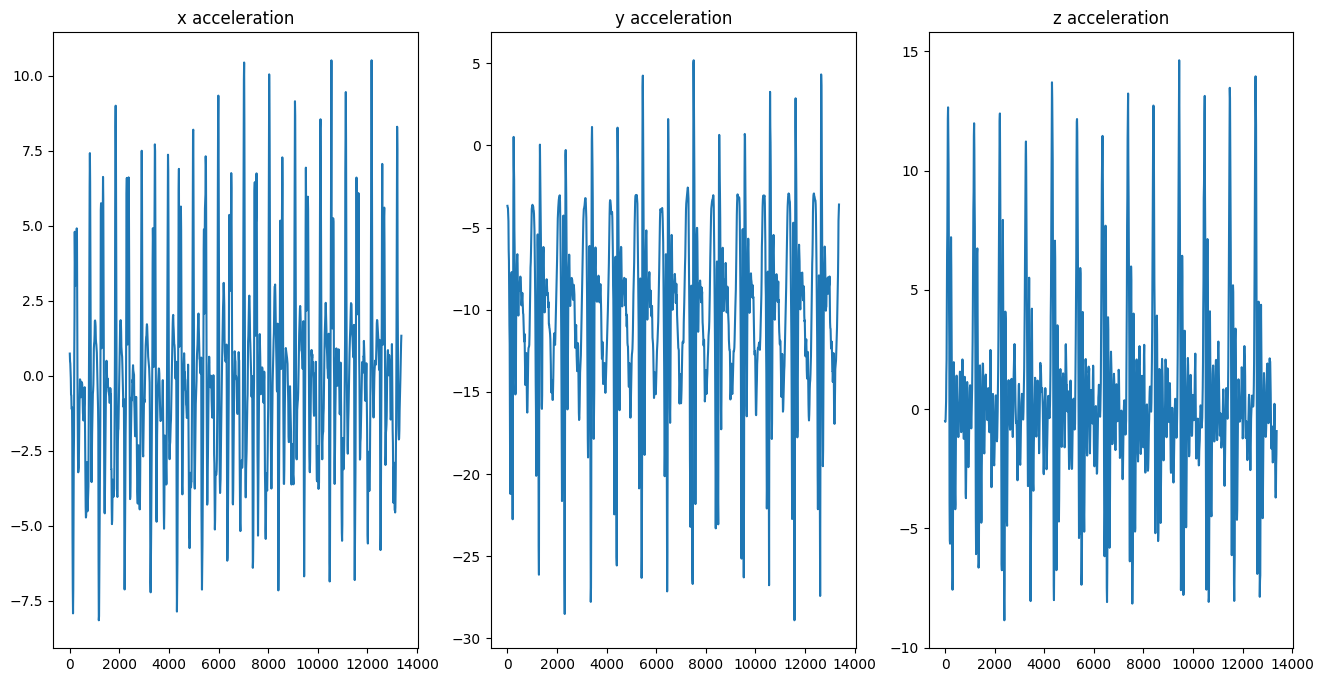

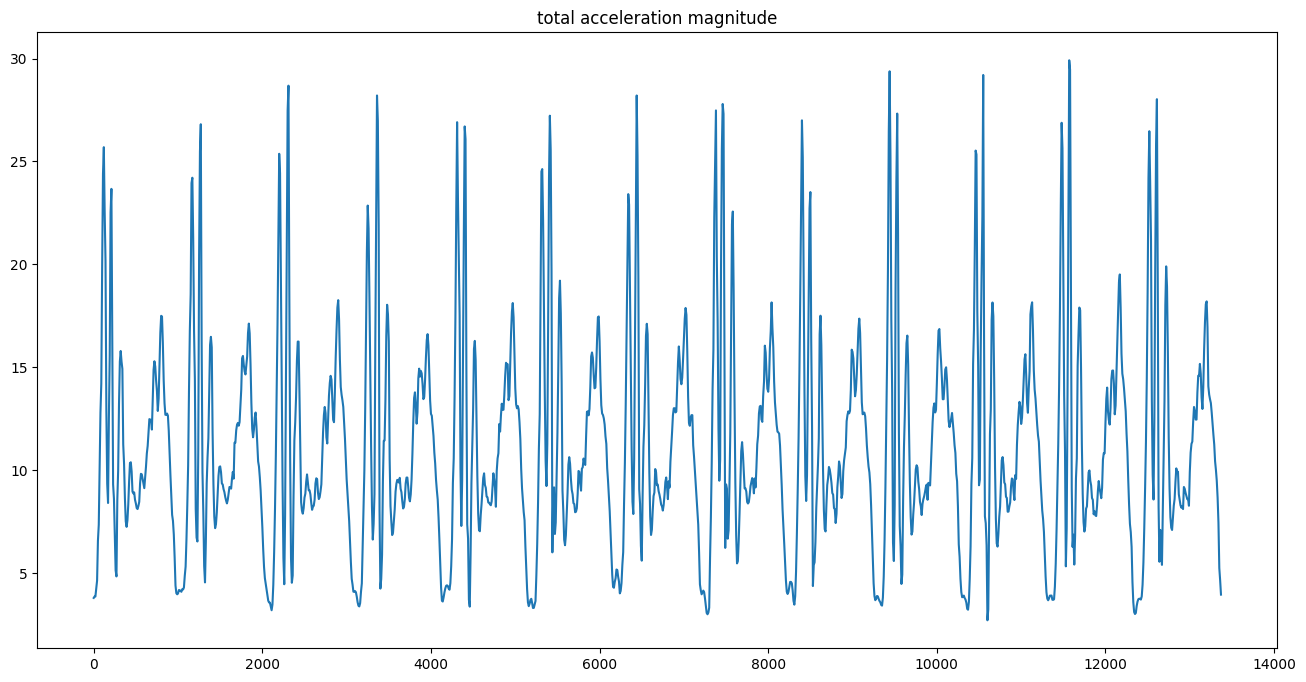

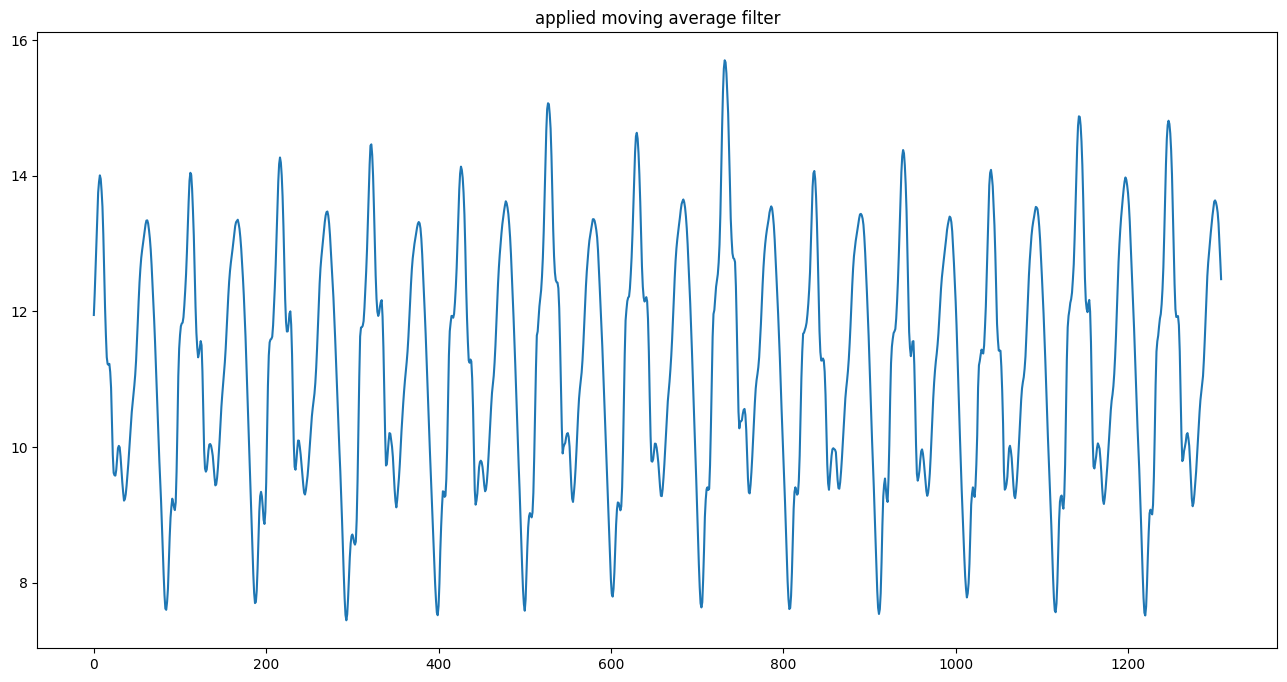

In [5]:
def moving_average(data, window_size):
    """Apply a moving average filter to the data."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


def get_step_length():
    """
    step length is approximated to be proportional to the height of pedestrian
    """
    
    height=1.75 # in meters
    return 0.415*height


def calculate_steps(accl_data):
    """
    :param accel_data: pandas dataframe with 3 columns, "x", "y", "z" representing acceleration in m/s^2 
    and index of dataframe is "timestamp"
    
    returns: pandas dataframe with 2 columns "timestamp" and "steplength" 
    
    for this MP assume that the step length is same for each step, 
    use the get_step_length function to get the step length
    
    the timestamp is the time when the step is detected
    
    NOTE: timestamps should be among the values in the timestamp column, 
    you are not expected to do any time interpolation
    """
    # replace the following dummy with your implementation
    np_accel_data = np.array(accl_data)
    x_data = np_accel_data[:,0] # x component of acceleration
    y_data = np_accel_data[:,1] # y component of acceleration
    z_data = np_accel_data[:,2] # z component of acceleration
    total_accel_data = np.array([np.linalg.norm(np_accel_data[i,:3]) for i in range(np_accel_data.shape[0])]) # total acceleration magnitude
    timesteps = np_accel_data[:,3] # timesteps (should be in increments of 10)
    
    print(total_accel_data)
    steps_array = np.zeros((len(timesteps), 2)) # steps np array, will be converted into pandas dataframe later
    steps_array[:,0] = timesteps
    plt.figure(figsize = (16,8))
    
    plt.subplot(131)
    plt.title("x acceleration")
    plt.plot(timesteps, x_data,scalex=10)
    
    plt.subplot(132)
    plt.title("y acceleration")
    plt.plot(timesteps,y_data)
    
    plt.subplot(133)
    plt.title("z acceleration")
    plt.plot(timesteps,z_data)
    
    # transformed_total = scipy.signal.savgol_filter(total_accel_data, 101, 2)
    
    plt.figure(figsize= (16,8))
    plt.title("total acceleration magnitude")
    plt.plot(timesteps, total_accel_data)
    
    plt.figure(figsize = (16,8))
    plt.title("applied moving average filter")
    averaged_filtered = moving_average(total_accel_data, 30)
    plt.plot(range(len(averaged_filtered)), averaged_filtered)
    
    peaks, _ = scipy.signal.find_peaks(total_accel_data, 0.78 * np.max(total_accel_data))
    print(peaks)
    # print(scipy.signal)
    steps = pd.DataFrame({"timestamp": np.sort(np.random.choice(accl_data.index, 10, replace=False)).tolist(), 
                          "steplength": get_step_length()})
    return steps

def calculate_final_position(steps_with_walking_direction, start_position):
    """ 
    :param steps_with_walking_direction: pandas dataframe with 3 columns "timestamp", "steplength", and "walking_direction"
    
    walking_direction is an angle in degrees with global frame x-axis. It can be from 0 degrees to 360 degrees.
    for e.g. if walking direction is 90 degrees, user is walking in the positive y-axis direction
    
    NOTE: In the given test cases, the walking direction is same through out the trajectory 
    but in hidden cases the walking direction may change
    
    step_length is in meters
    
    :param start_position: starting position of the user. It is tuple (x,y)
    
    return (x,y) coordinate of the final position in meters
    """
    np_steps = np.array(steps_with_walking_direction)
    timesteps = np_steps[:,0]
    steplengths = np_steps[:,1]
    angles = np_steps[:,2]
    cur_x, cur_y = start_position
    for i, steplength in enumerate(steplengths):
        cur_y += steplength * np.sin(angles[i] * np.pi / 180)
        cur_x += steplength * np.cos(angles[i] * np.pi / 180)
    
    
    return (cur_x, cur_y)
print(pd.read_csv("accel_data/inpocket_26steps.csv"))
calculate_steps(pd.read_csv("accel_data/inpocket_26steps.csv"))


### Run & Test
Use the cell below to run and test `calculate_steps(accl_data)` and `calculate_final_position(steps_with_walking_direction, start_position)`. 

[8.0092791  7.88750131 7.78730269 ... 7.01240954 6.77668551 6.54956881]
[  29   86   95  139  150  196  205  252  261  308  316  362  371  427
  473  482  528  535  584  590  635  643  688  698  739  745  753  797
  806  852  861  907  915  955  961  970 1015 1023 1066 1077]
[3.78699575 3.85267988 3.85493093 ... 5.24147297 4.64466601 3.94762124]
[  12   21  117  127  220  231  336  431  440  532  541  634  644  738
  746  840  850  944  953 1046 1055 1148 1157 1252 1261]
[9.98621753 9.85166506 9.29404562 ... 9.83952589 9.37525773 9.46302667]
[ 190  292  302  394  404  495  504  597  699  800  809  900  909  999
 1008 1100 1108 1201 1210 1303 1313 1407 1416 1511 1521 1628 1737 1845]
[12.79910679 12.96969198 13.17519084 ... 12.10565917 12.00362905
 11.87864748]
[  20   79  132  189  243  245  298  350  409  462  521  574  632  685
  742  793  850  897  906  965 1009 1019 1078 1123 1132 1192 1248 1301
 1305 1361 1420 1465 1474 1533 1537 1591 1652 1709 1770]
[ 6.03998782  6.95067329  6.978

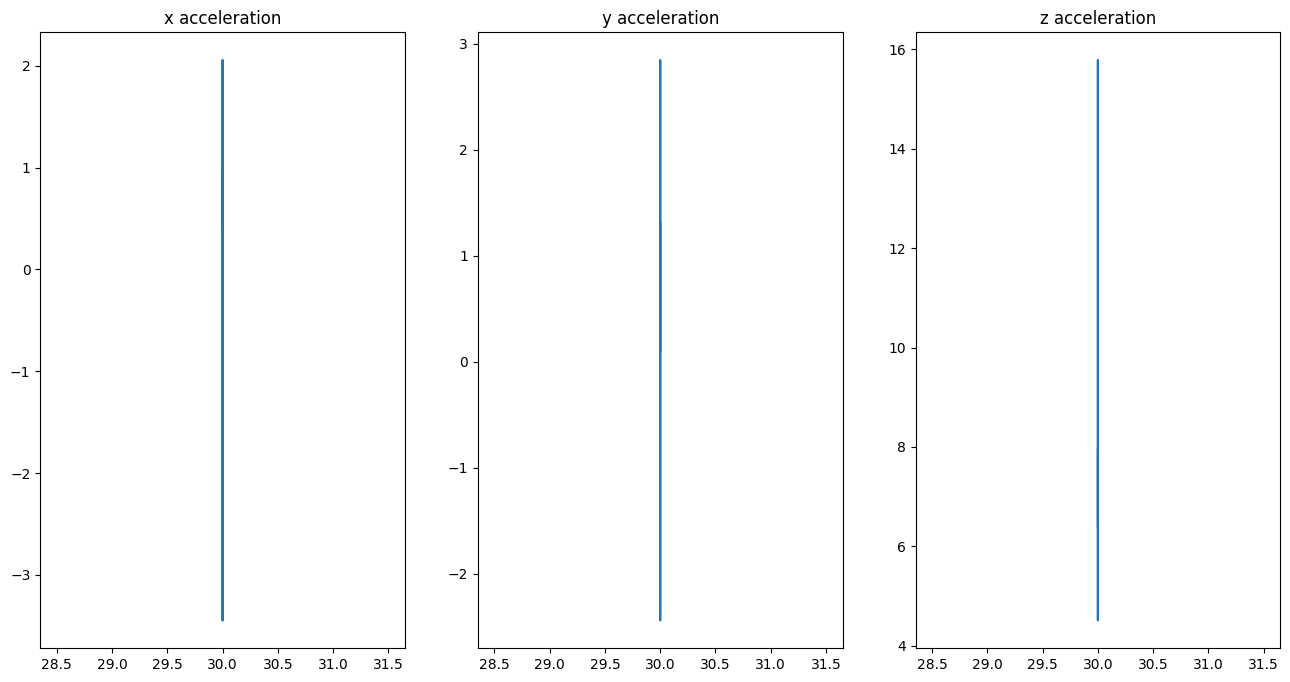

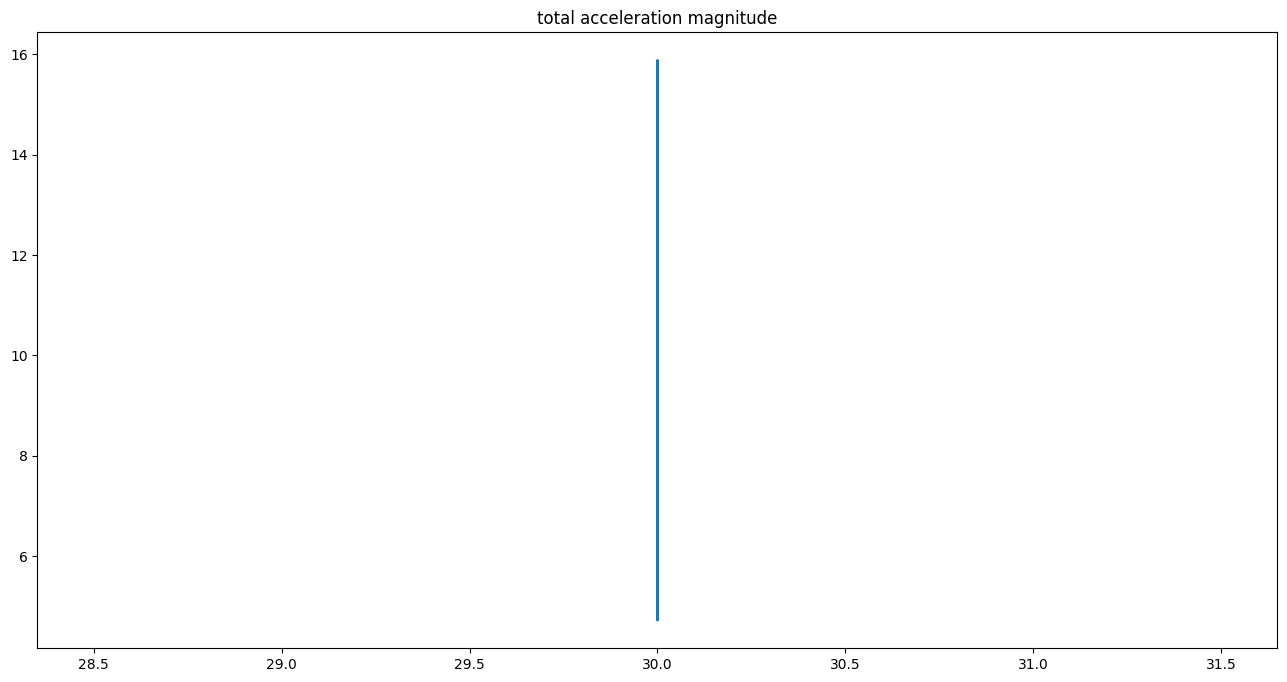

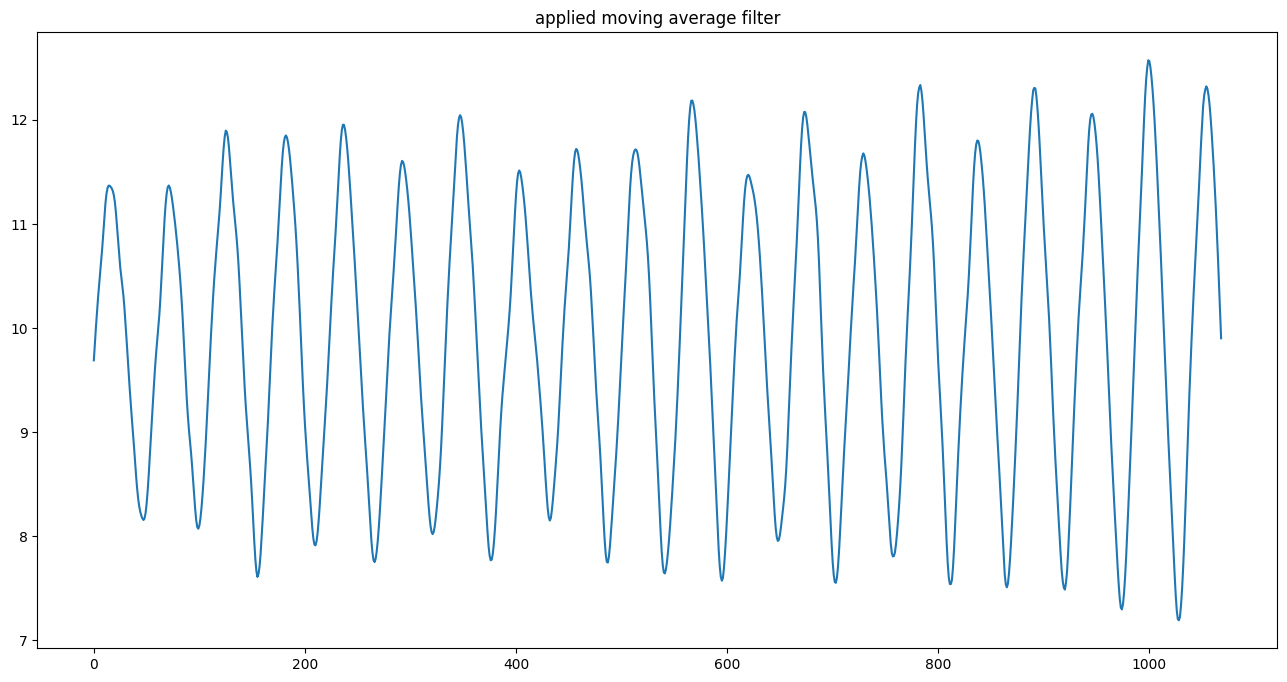

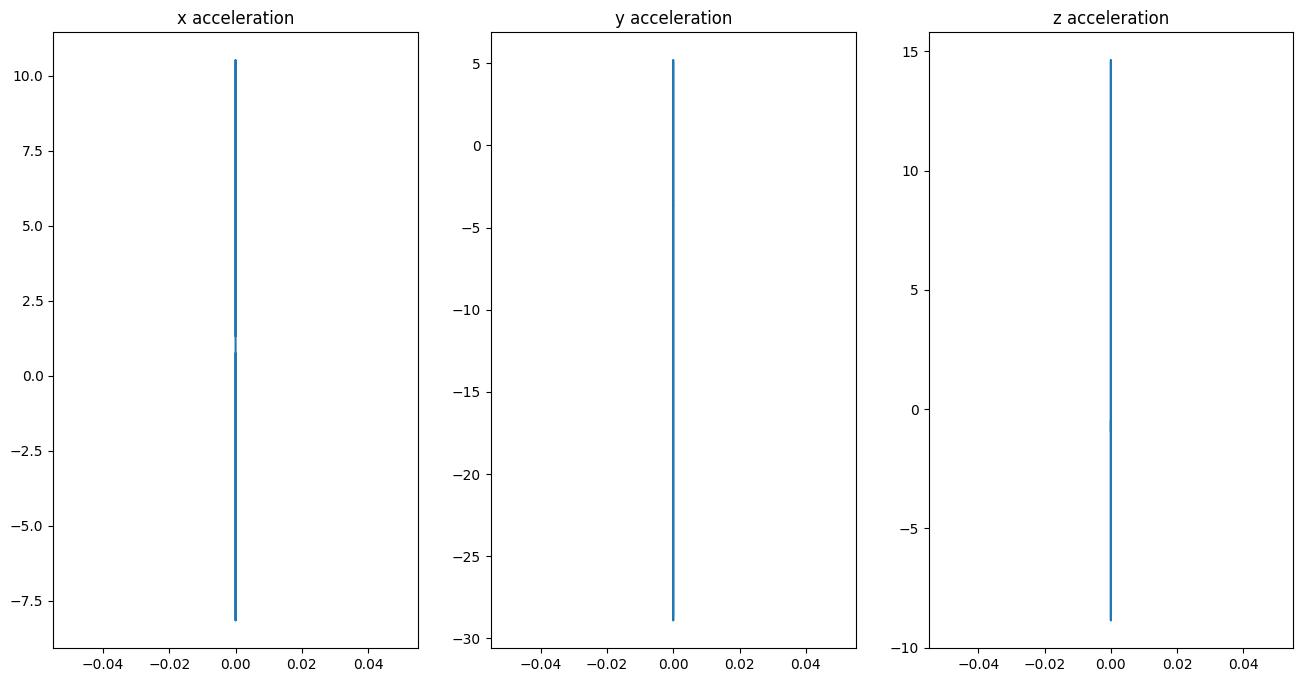

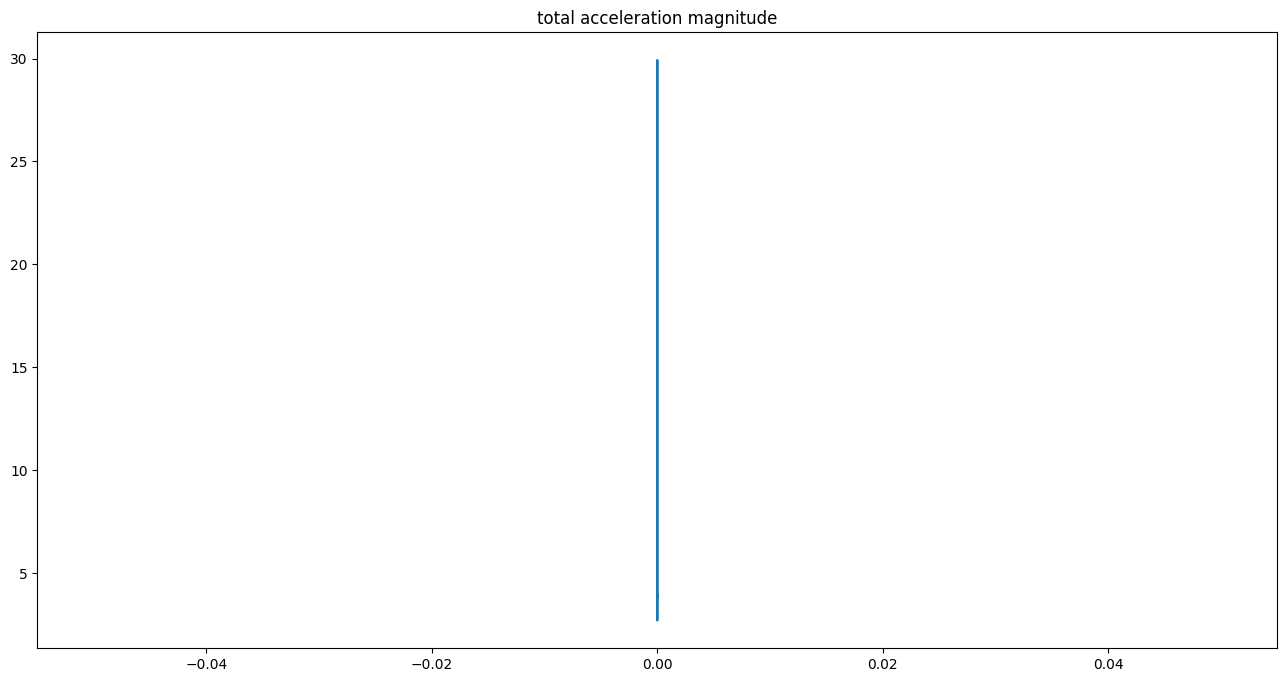

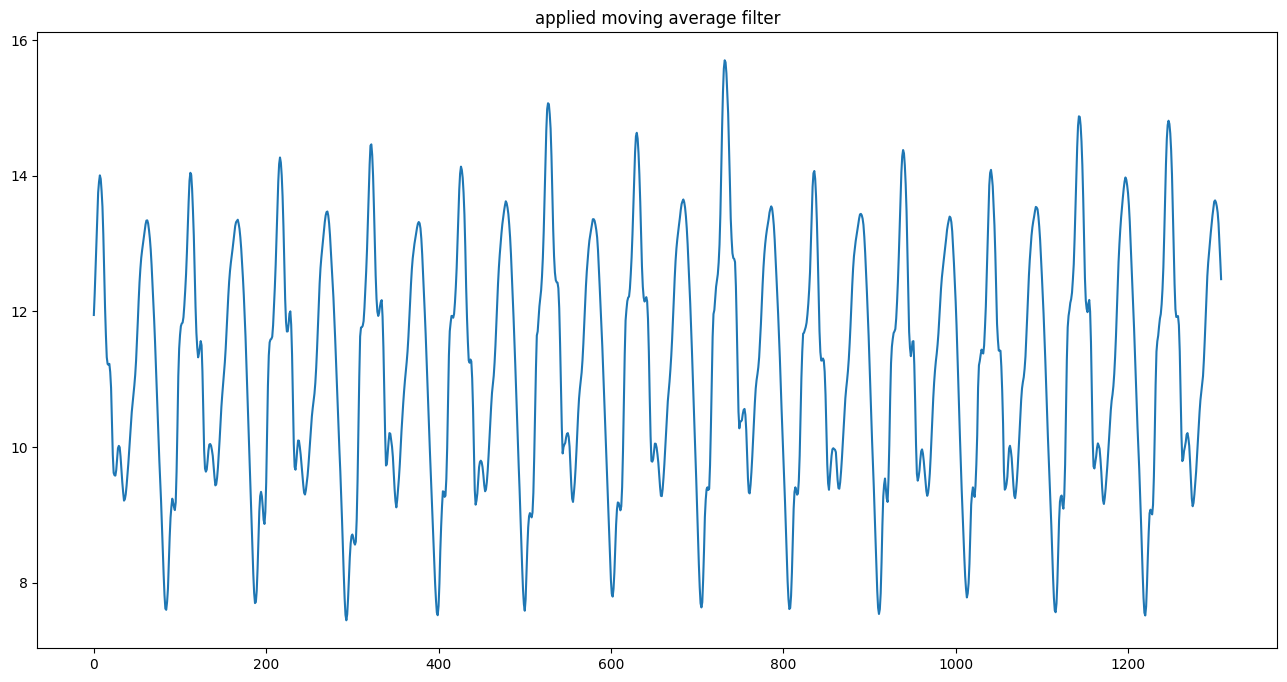

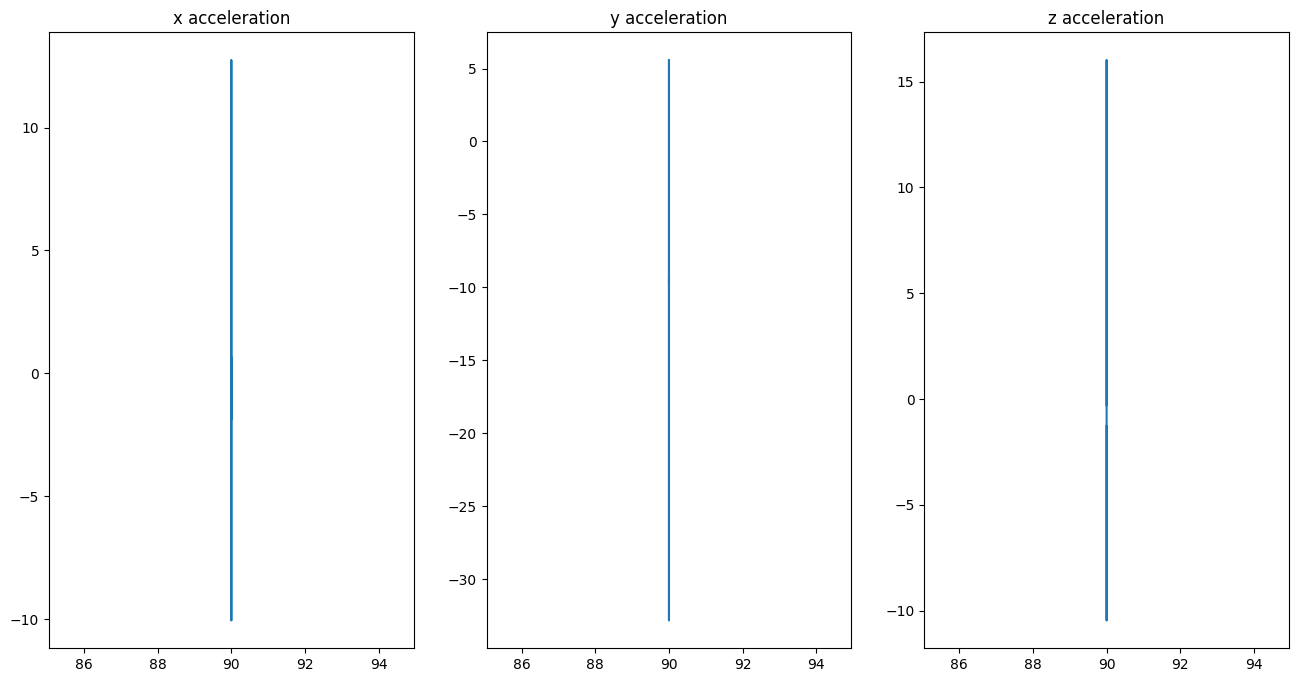

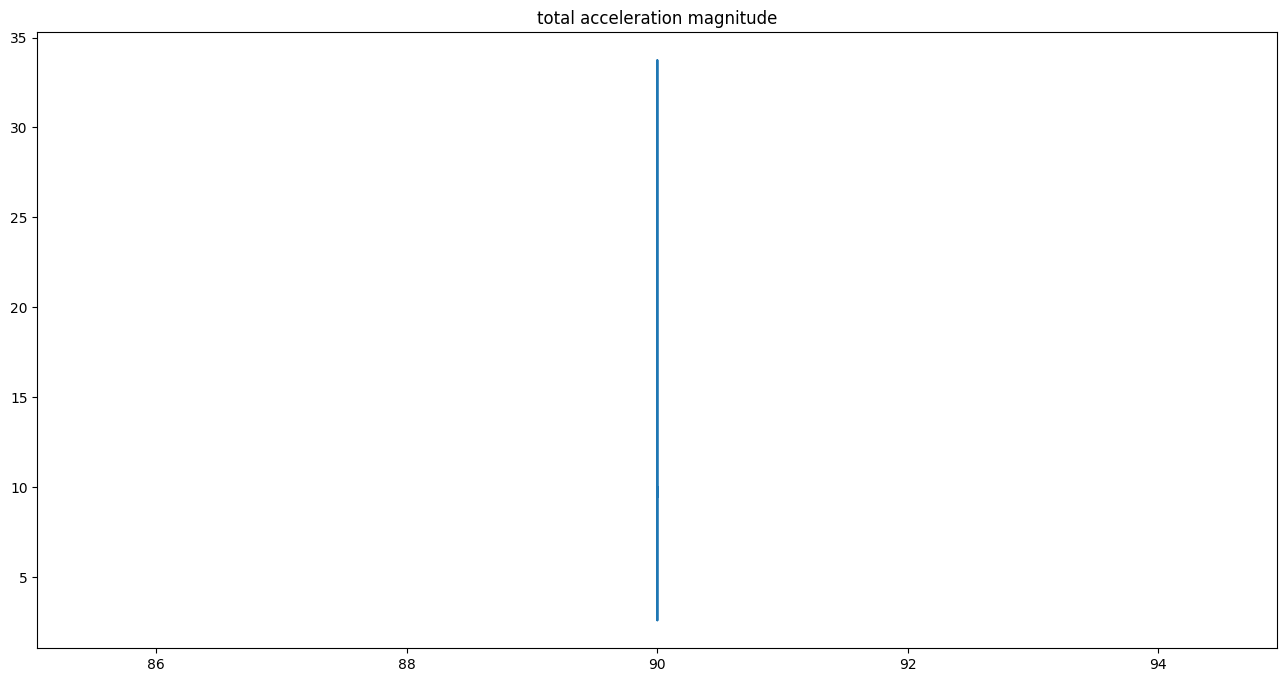

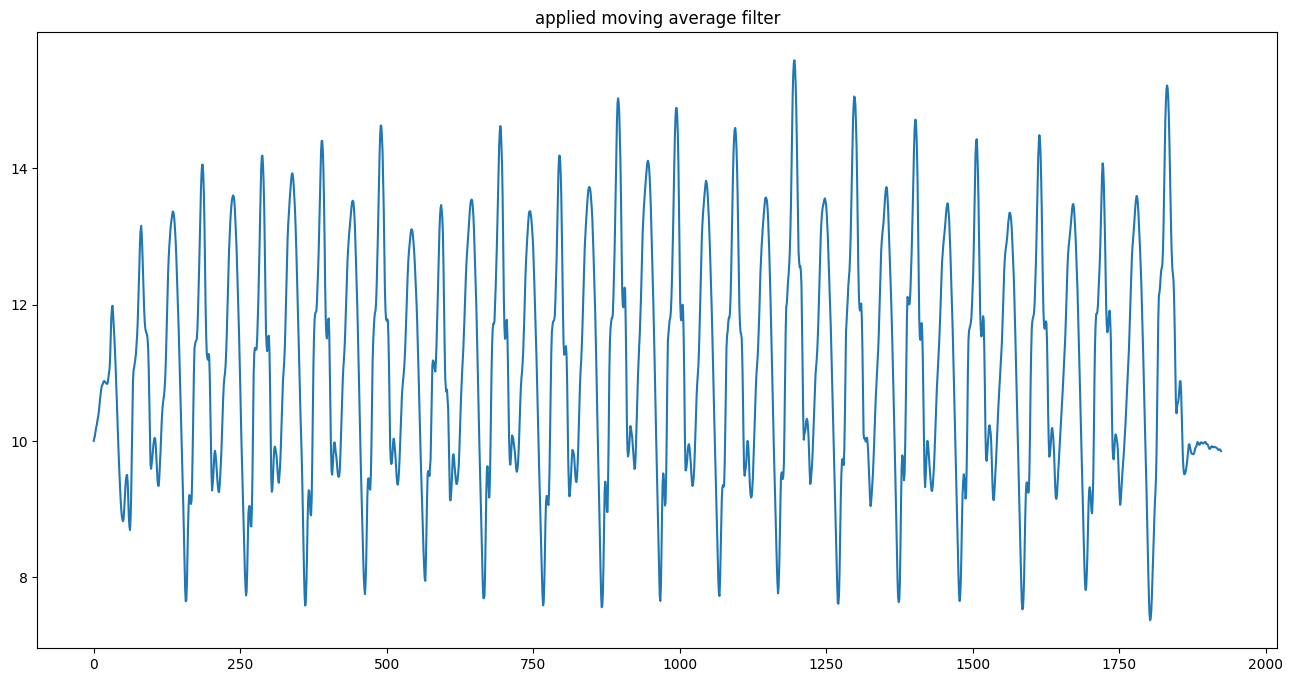

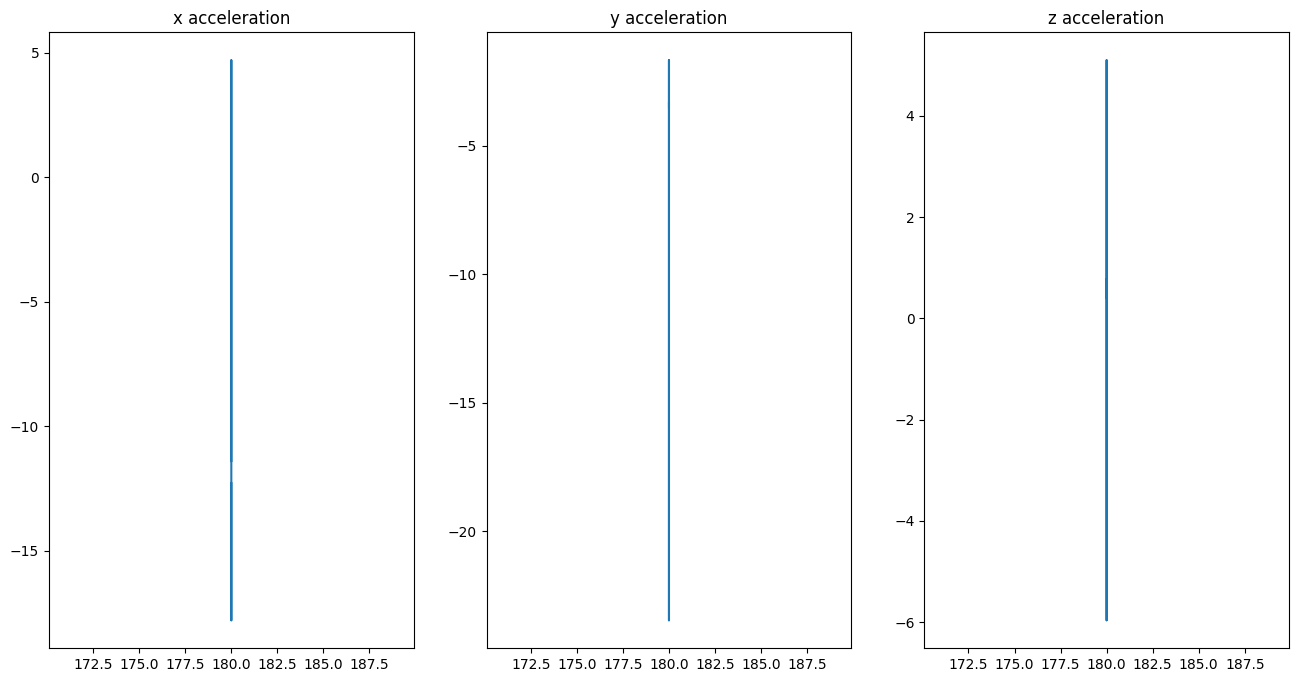

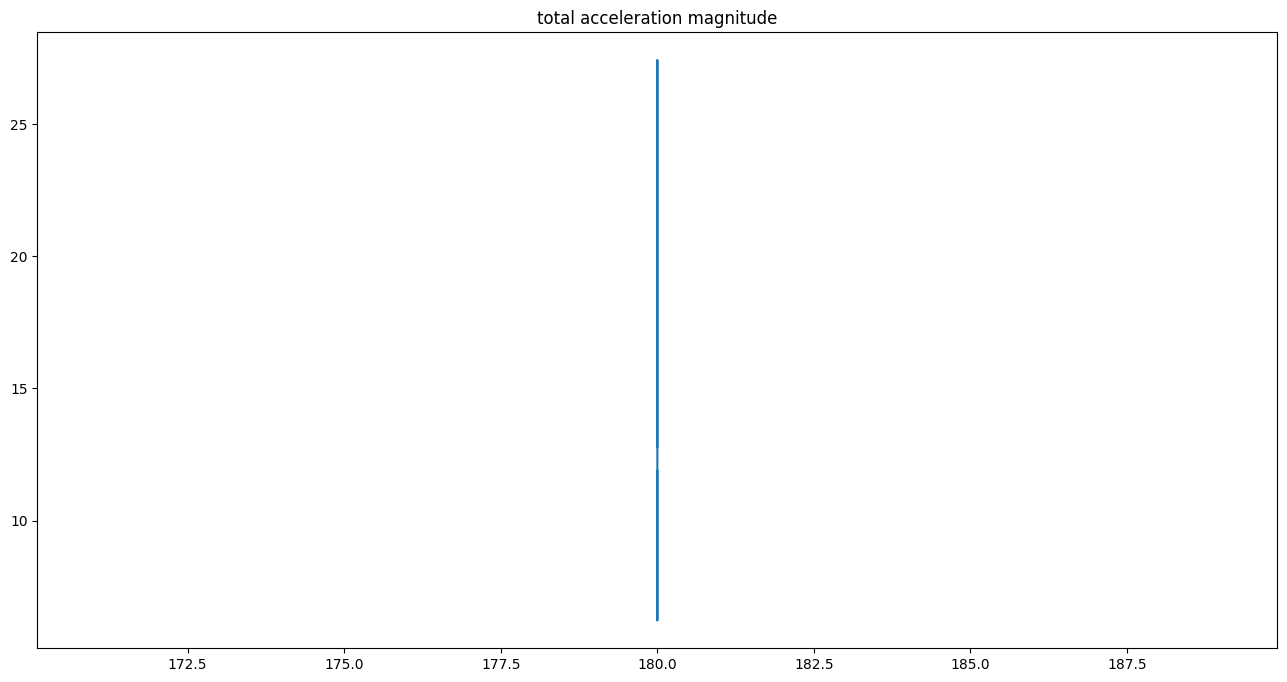

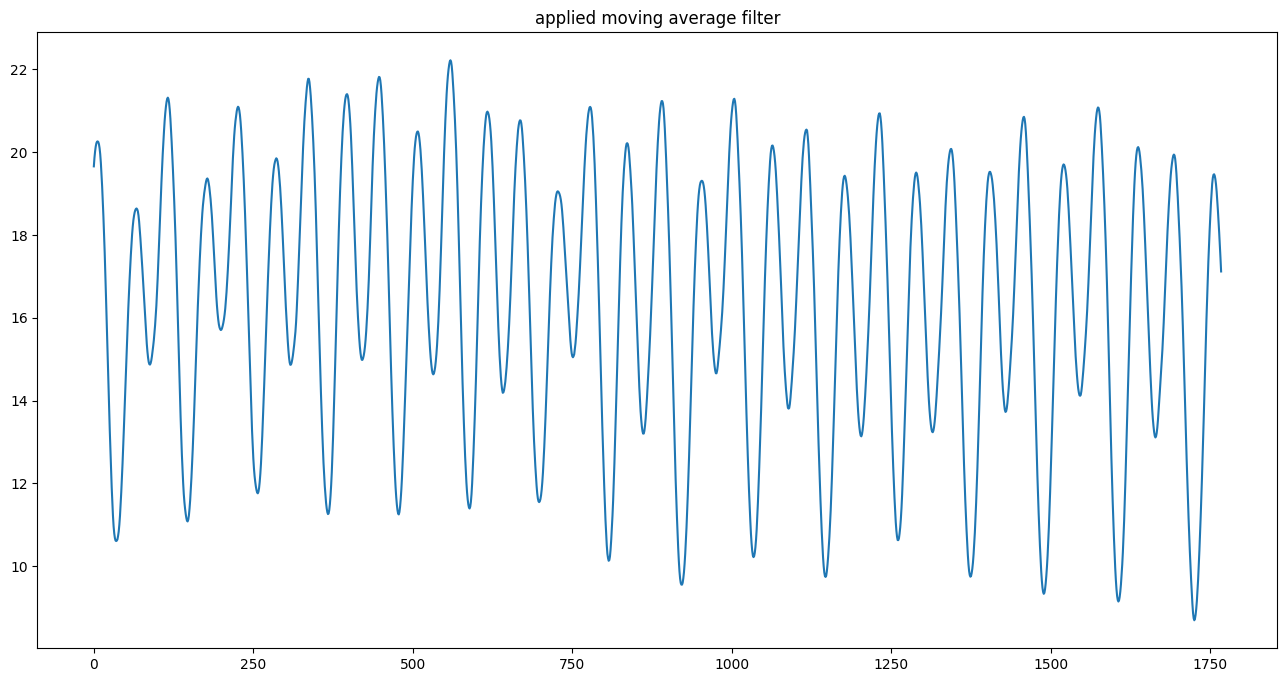

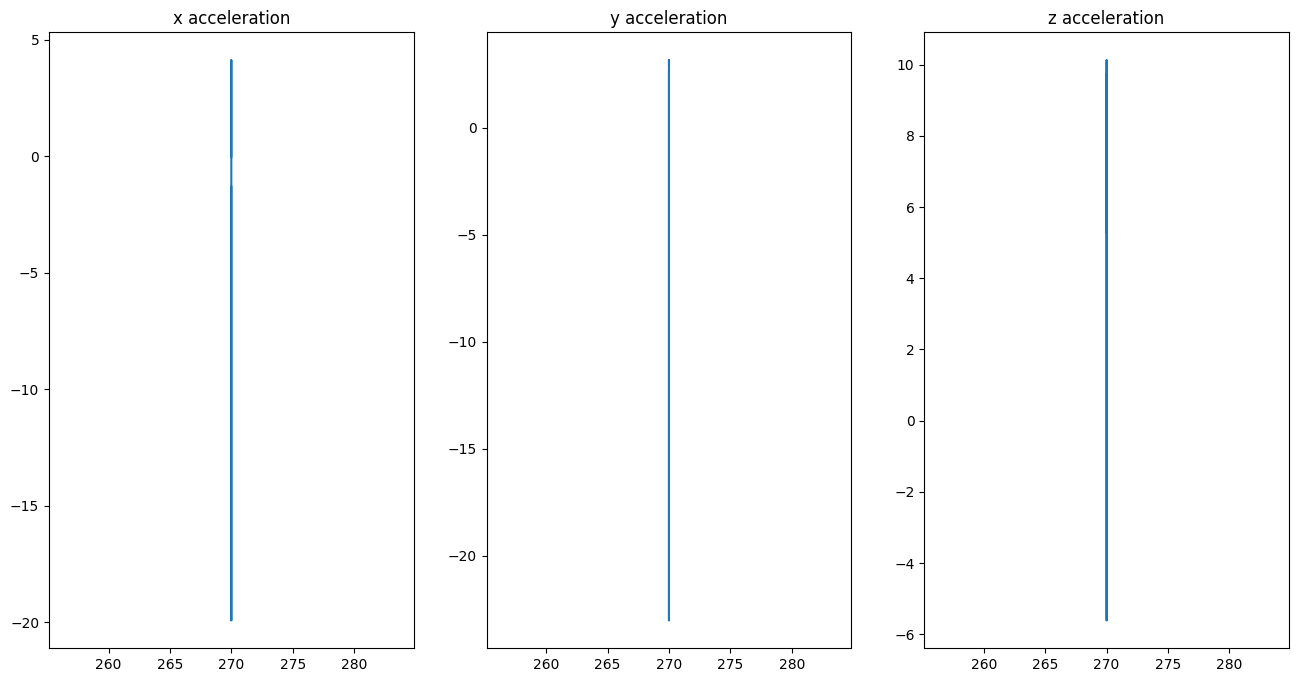

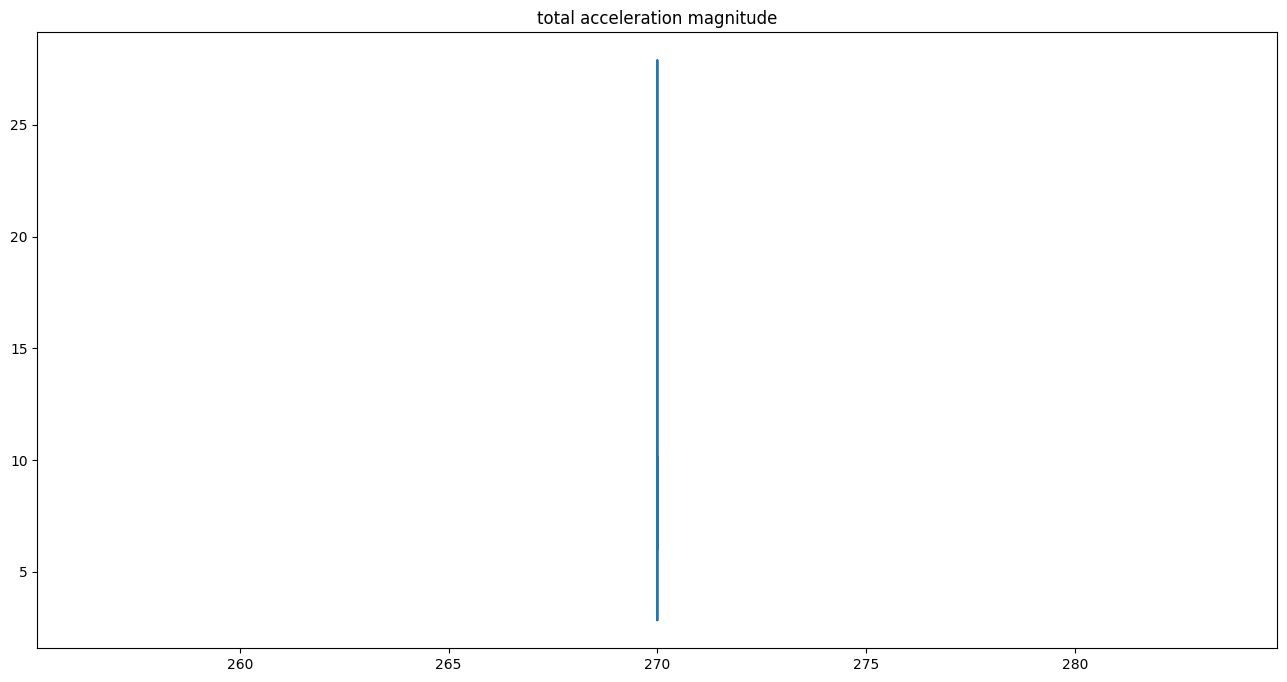

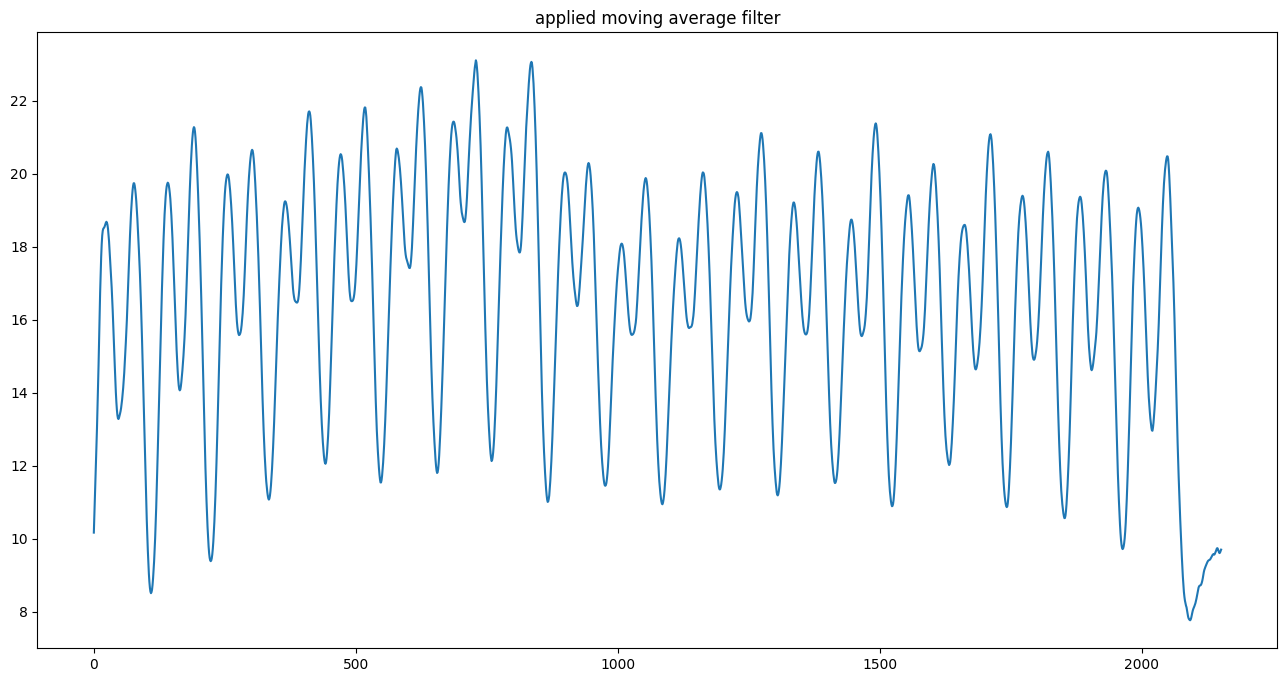

In [6]:
def estimate_steps_score(calculated, expected):
    delta = abs(calculated - expected)
    return 1 if(delta <= 2) else max((1 - abs(delta - 2) / expected), 0)

def estimate_pdr_score(calculated, expected):
    error = math.sqrt((calculated[0] - expected[0])**2 + (calculated[1] - expected[1])**2)
    # error more than 5 meters, score is 0
    return 1.0 if (error <= 2.0) else max(0, 1-(error-2.0)/3)


if __name__ == '__main__':
    data_dir = "accel_data"
    walk_accl_files = ['holdstatic_20steps.csv', 'inpocket_26steps.csv',
                       'inpocket_36steps.csv', 'swing_32steps.csv', 'swing_38steps.csv']
    groundtruth_numsteps = [20, 26, 36, 32, 38]
    groundtruth_final_positions = [(12.58, 7.26), (18.88, 0.0), (0.0, 26.14), (-23.24, 0.0), (0.0, -27.6)]
    output = [['Dataset', 'Expected Number Steps', 'Your Number of Steps', 'Expected Final Position', 'Your Final Position', 'Grade']]
    for i in range(len(groundtruth_numsteps)):
        accel_data = pd.read_csv(str(Path(data_dir) / walk_accl_files[i]))
        accel_data = accel_data.set_index("timestamp", drop=True)
        calculated = calculate_steps(accel_data)
        assert len(calculated.columns)==2
        assert "timestamp" in calculated.columns
        assert "steplength" in calculated.columns
        calculated_num_steps = calculated.shape[0]
        calculated["walking_direction"] = accel_data["walking_direction"][calculated["timestamp"]].values
        calculated_final_position = calculate_final_position(calculated, (0.0,0.0))
        steps_score = estimate_steps_score(calculated_num_steps, groundtruth_numsteps[i])
        pdr_score = estimate_pdr_score(calculated_final_position, groundtruth_final_positions[i])
        # final score is weighted sum of both scores
        score = 0.7*steps_score + 0.3*pdr_score
        output.append([walk_accl_files[i], groundtruth_numsteps[i],
                      calculated_num_steps, groundtruth_final_positions[i], calculated_final_position,  "{:2.2f} / 5.00".format(score * 5)])
    output.append(['<i>👻 Hidden test 1 👻</i>','<i>???</i>', '<i>???</i>','<i>???</i>', '<i>???</i>', '<i>???</i> / 15.00'])
    output.append(['<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>', '<i>...</i>'])
    output.append(['<i>👻 Hidden test 5 👻</i>','<i>???</i>', '<i>???</i>','<i>???</i>', '<i>???</i>', '<i>???</i> / 15.00'])
    display_table(output)

---
## Rubric

####  Orientation Tracking (100 points) 
You will be graded on the provided data as well as 4 addition sets of data. They are each worth 20 points. A 2-degree error is tolerated. For results greater than the error threshold, no points will be rewarded since we provided a detailed algorithm to follow. The test data also include the simple case where the phone will only rotate along Z axis onwards. (In case you find the MP too difficult, only doing 1D integration on Z axis should at least give you some points.)

#### Step Estimation (100 points) 
You will be graded on the 5 sets of provided data (5 points each), as well as 5 sets of hidden data (15 points each). For each test case, the grade depends on how much the result deviates from the groudtruth. A 2-step error for the provided data is tolerated. A 4-step error for the hidden data is tolerated. For results greater than the error threshold, your score will be scaled proportionally. The score is the weighted sum of PDR error i.e., deviation from the final position and the step count detection accuracy.

---
## Submission Guideline
This Jupyter notebook is the only file you need to submit on Gradescope. Make sure to fill your name at the top of this file.

**Make sure any code you added to this notebook, except for import statements, is either in a function or guarded by `__main__`(which won't be run by the autograder). Gradescope will give you immediate feedback using the provided test cases. It is your responsibility to check the output before the deadline to ensure your submission runs with the autograder.**